# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 7th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 2 octobre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "saphia"
ln1 = "benmansour"
fn2 = "hadrien"
ln2 = "piegard"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_benmansour_saphia_and_piegard_hadrien.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5,1,'Parameters / Coefficients')

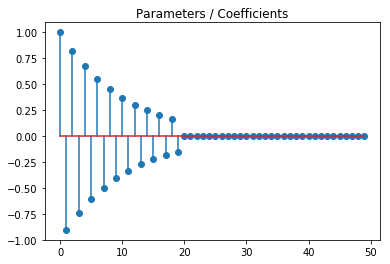

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [6]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x"""
    return np.sign(x) * np.maximum(np.abs(x) - s, 0)
    
def lasso(x, s):
    """Value of the Lasso penalization at x"""
    return s * np.linalg.norm(x, 1)

def prox_ridge(x, s):
    """Proximal operator for the ridge at x"""    
    return x / (1. + s)
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    return s / 2. * np.linalg.norm(x, 2) ** 2

## Comment



### Concerning the proximal operator for the lasso penalization:

We have

$$
\text{prox}_{s \|z\|_1}(x) = \arg\min_z \Big\{ \frac 12 \|x - z\|_2^2 + s \|z\|_1) \Big\}.
$$


We saw  that the prox operator of the L1 norm is the soft thresholding operator, so :

$$ 
\text{prox}_{s \|z\|_1}(x) = \left\{
    \begin{array}{ll}
       z-s  \text{ if } s < z \\
       0  \text{ if } | z |  \leq s \\
       z+s \text{ if }  z < -s
    \end{array}
\right.
$$

Therefore,
$$ \text{z} = max (sign(x)(| x | - s), 0) $$


### Concerning the proximal operator for the ridge penalization:
$$
\text{prox}_{\frac{s}{2} \|z\|_2^2}(x) = \arg\min_x \Big\{ \frac 12 \|x - z\|_2^2 + \frac{s}{2} \|z\|_2^2 \Big\}.
$$

We take $ f(z) = \frac 12 \|x - z\|_2^2 + \frac{s}{2} \|z\|_2^2. $


While applying the differenciation we get  
$ f(x)$ : 
$ \nabla f(z)= (z-x)+ s\cdot z $.

$ \Rightarrow  \nabla f(z)= 0$ if $z = \frac{x}{1 + s}$


Finally:
$$ \text{prox}_{\frac{s}{2} \|z\|_2^2}(x) =\frac{x}{1+ s} $$



## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

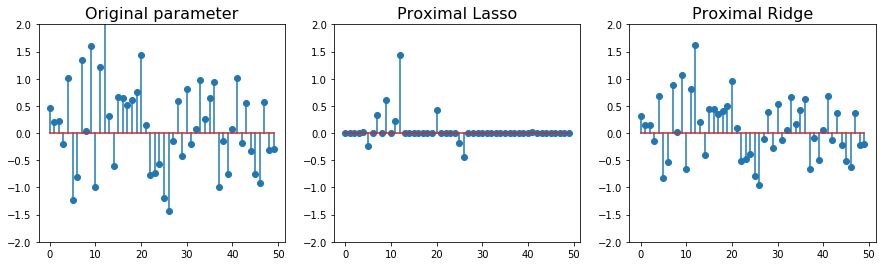

In [7]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

## Observations
 
While using the lasso reg, if the absolute value of the coefficients is smaller then $s$, then it's now turned into 0, as we have $ \text{sign}(x)(|x|-s)_{+} $. However, the non-null remaining coefficients are reduced by the scalar $s$. This has created sparsity.

While using the ridge reg, the coefficients are just shrinked by the factor $\frac{1}{1 + s}$.


## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [8]:
from scipy.optimize import check_grad

A, b = simu_linreg(coefs)

def loss_linreg(x, A=A, b=b):
    """Least-squares loss"""
    return 1. / (2. * len(b)) * np.linalg.norm(b-np.dot(A, x), 2) ** 2

def grad_linreg(x, A=A, b=b):
    """Least-squares gradient"""
    return (np.dot(A.T, np.dot(A, x) - b)) / len(b)
    
def loss_logreg(x, A=A, b=b):
    """Logistic loss"""
    return np.mean(np.log(1. + np.exp(-b * np.dot(A, x)))) 
    
def grad_logreg(x, A=A, b=b):
    """Logistic gradient"""
    return - np.mean(b * A.T * (1. / (1. + np.exp(b * np.dot(A, x)))), axis=1)

In [9]:
A, b = simu_linreg(coefs)
print(check_grad(loss_linreg, grad_linreg, np.ones(50))) 
A, b = simu_logreg(coefs)
print(check_grad(loss_logreg, grad_logreg, np.ones(50)))

6.437973254107909e-06
4.35859772391593e-07


## Observations
 
The computed gradients seem correct as the two check_grad are small.


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [10]:
norm = np.linalg.norm

def lip_linreg(A):
    """Lipschitz constant for linear squares loss"""  
    return 1. / len(b) * norm(A, 2.) ** 2.

## Comment

### Linear regression:
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

Differenciating $f(x)$ once gives : $\nabla f(x) = -\frac{A^\top}{n}(b - A x) $

$ 	\Rightarrow \| \nabla f(x) - \nabla f(y)\| \leq \| \frac{A^\top A}{n}\| \| x - y\| $,  $ \forall	  x,y \in \mathbb{R^2}$

Conclusion: the Lipschitz constant for linear regression is * $ \| \frac{A^\top A}{n}\| $ *.

In [11]:
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""  
    return 1. / (4. * len(b)) * norm(A, 2.) ** 2.

## Comment


### Logistic regression:
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.


The smoothness constant for the logistic regression is proven to be equal to ** $  \frac{\|A^\top A\|}{4n} $ ** in the last exercise on smoothness. 

In [12]:
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm"""
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x = prox_g(x - step * grad_f(x), s)
    
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [13]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
    for k in range(n_iter + 1):
    
        x_new = prox_g(z - step * grad_f(z), s)
        t_new = (1. + np.sqrt(1. + 4. * t ** 2.)) / 2. 
        z = x_new + (t - 1.) / t_new * (x_new - x)
        x, t = x_new, t_new
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [14]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    </ul>
</div>

In [15]:
A , b = simu_linreg(coefs)
x, obj, err =fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, 1. / lip_linreg(A), s, n_iter=1000,
         x_true=coefs, verbose=True)
print("Minimum:", obj[-1])
print("Minimizers:", x)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.29e+00 | 8.88e-01
      10 | 5.22e-01 | 1.43e-01
      20 | 5.22e-01 | 1.38e-01
      30 | 5.22e-01 | 1.38e-01
      40 | 5.22e-01 | 1.38e-01
      50 | 5.22e-01 | 1.38e-01
      60 | 5.22e-01 | 1.38e-01
      70 | 5.22e-01 | 1.38e-01
      80 | 5.22e-01 | 1.38e-01
      90 | 5.22e-01 | 1.38e-01
     100 | 5.22e-01 | 1.38e-01
     110 | 5.22e-01 | 1.38e-01
     120 | 5.22e-01 | 1.38e-01
     130 | 5.22e-01 | 1.38e-01
     140 | 5.22e-01 | 1.38e-01
     150 | 5.22e-01 | 1.38e-01
     160 | 5.22e-01 | 1.38e-01
     170 | 5.22e-01 | 1.38e-01
     180 | 5.22e-01 | 1.38e-01
     190 | 5.22e-01 | 1.38e-01
     200 | 5.22e-01 | 1.38e-01
     210 | 5.22e-01 | 1.38e-01
     220 | 5.22e-01 | 1.38e-01
     230 | 5.22e-01 | 1.38e-01
     240 | 5.22e-01 | 1.38e-01
     250 | 5.22e-01 | 1.38e-01
     260 | 5.22e-01 | 1.38e-01
     270 | 5.22e-01 | 1.38e-01
     280 | 5.22e-01 | 1.38e-01
     290 | 5.22e-01 | 1.38e-01
     300 | 5.2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
     
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

### Comparing the convergences of ISTA and FISTA  in terms of distance to the minimum and distance to the minimizer for logistic and linear regression with lasso and ridge penalisation 


In [16]:
# Comparing the convergences of ISTA and FISTA  in terms of distance to the minimum and distance to the minimizer for logistic and linear regression with lasso and ridge penalisation 

X_f={}
obj_f={}
err_f={}

X_i={}
obj_i={}
err_i={}

for reg in ["lg", "ln"]:
    if reg == "lg":
        A , b = simu_logreg(coefs)
        f = loss_logreg
        grad_f = grad_logreg
        step = 1. / lip_logreg(A)
    else:
        A , b = simu_linreg(coefs)
        f = loss_linreg
        grad_f = grad_linreg
        step = 1. / lip_linreg(A)
    for pen in ["ls", "rd"]:
        if pen == "ls":
            g = lasso
            prox_g = prox_lasso
        else:
            g = ridge
            prox_g = prox_ridge
            
        #precomputation
        xf, objf, errf = fista(x0, f, grad_f, g, prox_g, step, s, n_iter=2000, x_true=coefs, verbose=False)
        xi, obji, erri = ista(x0, f, grad_f, g, prox_g, step, s, n_iter=2000, x_true=coefs, verbose=False)
        #computation
        X_f["X_f_{}_{}".format(reg,pen)],obj_f["obj_f_{}_{}".format(reg,pen)],err_f["err_f_{}_{}".format(reg,pen)] = fista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=xf, verbose=True)
        X_i["X_i_{}_{}".format(reg,pen)],obj_i["obj_i_{}_{}".format(reg,pen)],err_i["err_i_{}_{}".format(reg,pen)] = ista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=xi, verbose=True)

        
        

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.45e-01 | 7.83e-01
      10 | 4.50e-01 | 1.97e-01
      20 | 4.51e-01 | 3.06e-02
      30 | 4.51e-01 | 3.54e-02
      40 | 4.50e-01 | 1.04e-02
      50 | 4.50e-01 | 1.19e-02
      60 | 4.51e-01 | 5.83e-03
      70 | 4.51e-01 | 4.98e-03
      80 | 4.50e-01 | 3.47e-03
      90 | 4.50e-01 | 2.19e-03
     100 | 4.51e-01 | 2.19e-03
     110 | 4.51e-01 | 9.71e-04
     120 | 4.50e-01 | 1.40e-03
     130 | 4.51e-01 | 3.93e-04
     140 | 4.51e-01 | 8.99e-04
     150 | 4.51e-01 | 1.24e-04
     160 | 4.51e-01 | 5.77e-04
     170 | 4.51e-01 | 7.68e-07
     180 | 4.51e-01 | 3.69e-04
     190 | 4.51e-01 | 5.03e-05
     200 | 4.51e-01 | 2.33e-04
     210 | 4.51e-01 | 6.51e-05
     220 | 4.51e-01 | 1.44e-04
     230 | 4.51e-01 | 6.32e-05
     240 | 4.51e-01 | 8.76e-05
     250 | 4.51e-01 | 5.47e-05
     260 | 4.51e-01 | 5.14e-05
     270 | 4.51e-01 | 4.43e-05
     280 | 4.51e-01 | 2.87e-05
     290 | 4.51e-01 | 3.43e-05
     300 | 4.5

     780 | 3.91e-01 | 1.52e-09
     790 | 3.91e-01 | 3.72e-09
     800 | 3.91e-01 | 1.08e-10
     810 | 3.91e-01 | 2.69e-09
     820 | 3.91e-01 | 6.29e-10
     830 | 3.91e-01 | 1.75e-09
     840 | 3.91e-01 | 9.11e-10
     850 | 3.91e-01 | 1.01e-09
     860 | 3.91e-01 | 9.19e-10
     870 | 3.91e-01 | 4.84e-10
     880 | 3.91e-01 | 7.85e-10
     890 | 3.91e-01 | 1.40e-10
     900 | 3.91e-01 | 6.00e-10
     910 | 3.91e-01 | 5.74e-11
     920 | 3.91e-01 | 4.15e-10
     930 | 3.91e-01 | 1.51e-10
     940 | 3.91e-01 | 2.58e-10
     950 | 3.91e-01 | 1.76e-10
     960 | 3.91e-01 | 1.39e-10
     970 | 3.91e-01 | 1.63e-10
     980 | 3.91e-01 | 5.68e-11
     990 | 3.91e-01 | 1.32e-10
    1000 | 3.91e-01 | 5.95e-12
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.20e-01 | 8.01e-01
      10 | 4.10e-01 | 4.37e-01
      20 | 3.97e-01 | 2.90e-01
      30 | 3.93e-01 | 2.01e-01
      40 | 3.91e-01 | 1.43e-01
      50 | 3.91e-01 | 1.03e-01
      60 | 3.91e-01 | 7.49e-02
      70 | 3.91

     470 | 6.05e-01 | 3.64e-18
     480 | 6.05e-01 | 0.00e+00
     490 | 6.05e-01 | 3.64e-18
     500 | 6.05e-01 | 0.00e+00
     510 | 6.05e-01 | 3.64e-18
     520 | 6.05e-01 | 0.00e+00
     530 | 6.05e-01 | 3.64e-18
     540 | 6.05e-01 | 0.00e+00
     550 | 6.05e-01 | 3.64e-18
     560 | 6.05e-01 | 0.00e+00
     570 | 6.05e-01 | 3.64e-18
     580 | 6.05e-01 | 0.00e+00
     590 | 6.05e-01 | 3.64e-18
     600 | 6.05e-01 | 0.00e+00
     610 | 6.05e-01 | 3.64e-18
     620 | 6.05e-01 | 0.00e+00
     630 | 6.05e-01 | 3.64e-18
     640 | 6.05e-01 | 0.00e+00
     650 | 6.05e-01 | 3.64e-18
     660 | 6.05e-01 | 0.00e+00
     670 | 6.05e-01 | 3.64e-18
     680 | 6.05e-01 | 0.00e+00
     690 | 6.05e-01 | 3.64e-18
     700 | 6.05e-01 | 0.00e+00
     710 | 6.05e-01 | 3.64e-18
     720 | 6.05e-01 | 0.00e+00
     730 | 6.05e-01 | 3.64e-18
     740 | 6.05e-01 | 0.00e+00
     750 | 6.05e-01 | 3.64e-18
     760 | 6.05e-01 | 0.00e+00
     770 | 6.05e-01 | 3.64e-18
     780 | 6.05e-01 | 0.00e+00
     790

### Distance to the minimum for ISTA and FISTA- Lasso


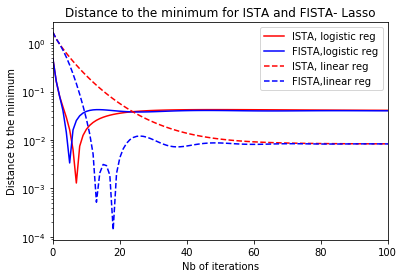

In [17]:
#Distance to the minimum for ISTA and FISTA- Lasso
true_obj_lin = loss_linreg(coefs) + lasso(coefs, s)
true_obj_log = loss_logreg(coefs) + lasso(coefs, s)

plt.plot(abs(obj_i["obj_i_lg_ls"] - true_obj_log) / true_obj_log,'r', label = "ISTA, logistic reg")
plt.plot(abs(obj_f["obj_f_lg_ls"] - true_obj_log) / true_obj_log,'b', label = "FISTA,logistic reg")
plt.plot(abs(obj_i["obj_i_ln_ls"] - true_obj_lin) / true_obj_lin,'r--', label = "ISTA, linear reg")
plt.plot(abs(obj_f["obj_f_ln_ls"] - true_obj_lin) / true_obj_lin,'b--', label = "FISTA,linear reg")
plt.yscale('log')
plt.xlabel("Nb of iterations")
plt.ylabel("Distance to the minimum")
plt.legend()
plt.title("Distance to the minimum for ISTA and FISTA- Lasso")
plt.xlim(0,100)
plt.show()

### Distance to the minimum for ISTA anf FISTA- Ridge


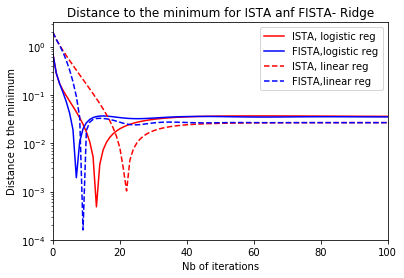

In [18]:
#Distance to the minimum for ISTA anf FISTA- Ridge
true_obj_lin = loss_linreg(coefs) + ridge(coefs, s)
true_obj_log = loss_logreg(coefs) + ridge(coefs, s)

plt.plot(abs(obj_i["obj_i_lg_rd"] - true_obj_log) /  true_obj_log,'r', label = "ISTA, logistic reg")
plt.plot(abs(obj_f["obj_f_lg_rd"] - true_obj_log) /  true_obj_log,'b', label = "FISTA,logistic reg")
plt.plot(abs(obj_i["obj_i_ln_rd"] -  true_obj_lin) /  true_obj_lin,'r--', label = "ISTA, linear reg")
plt.plot(abs(obj_f["obj_f_ln_rd"] -  true_obj_lin) /  true_obj_lin,'b--', label = "FISTA,linear reg")
plt.yscale('log')
plt.xlabel("Nb of iterations")
plt.ylabel("Distance to the minimum")
plt.legend()
plt.title("Distance to the minimum for ISTA anf FISTA- Ridge")
plt.xlim(0,100)
plt.show()

### Distance to the minimizer for ISTA anf FISTA- Lasso

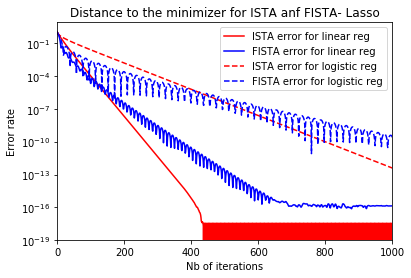

In [19]:
#Distance to the minimizer for ISTA anf FISTA- Lasso
plt.plot(err_i["err_i_ln_ls"],'r', label = "ISTA error for linear reg")
plt.plot(err_f["err_f_ln_ls"],'b', label = "FISTA error for linear reg")
plt.plot(err_i["err_i_lg_ls"],'r--', label = "ISTA error for logistic reg")
plt.plot(err_f["err_f_lg_ls"],'b--', label = "FISTA error for logistic reg")
plt.yscale('log')
plt.xlabel("Nb of iterations")
plt.ylabel("Error rate")
plt.legend()
plt.title("Distance to the minimizer for ISTA anf FISTA- Lasso")
plt.xlim(0,1000)
plt.show()

### Distance to the minimizer for ISTA and FISTA - Ridge


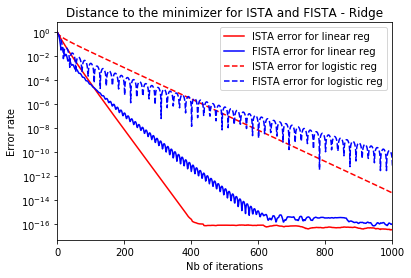

In [46]:
#Distance to the minimizer for ISTA and FISTA - Ridge
plt.plot(err_i["err_i_ln_rd"],'r', label = "ISTA error for linear reg")
plt.plot(err_f["err_f_ln_rd"],'b', label = "FISTA error for linear reg")
plt.plot(err_i["err_i_lg_rd"],'r--', label = "ISTA error for logistic reg")
plt.plot(err_f["err_f_lg_rd"],'b--', label = "FISTA error for logistic reg")
plt.yscale('log')
plt.xlabel("Nb of iterations")
plt.ylabel("Error rate")
plt.legend()
plt.title("Distance to the minimizer for ISTA and FISTA - Ridge")
plt.xlim(0,1000)
plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

### The influence of the correlation of the features on the performance of the optimization algorithms.

### Fista

#### Linear regression (Ridge + Lasso)

In [21]:
Constante_lin = []

A, b = simu_linreg(coefs, n_samples=200, corr=0.2)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
low_rf = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
low_lf = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
med_rf = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
med_lf = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=200, corr=0.8)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
high_rf = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
high_lf = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200) 

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.18e+00 | 8.36e-01
      10 | 5.19e-01 | 1.06e-01
      20 | 5.27e-01 | 1.31e-01
      30 | 9.35e-01 | 2.49e-01
      40 | 3.69e+01 | 2.00e+00
      50 | 3.77e+03 | 2.03e+01
      60 | 4.36e+05 | 2.18e+02
      70 | 5.44e+07 | 2.44e+03
      80 | 7.19e+09 | 2.80e+04
      90 | 9.92e+11 | 3.29e+05
     100 | 1.42e+14 | 3.93e+06
     110 | 2.08e+16 | 4.77e+07
     120 | 3.14e+18 | 5.85e+08
     130 | 4.81e+20 | 7.25e+09
     140 | 7.52e+22 | 9.06e+10
     150 | 1.19e+25 | 1.14e+12
     160 | 1.91e+27 | 1.44e+13
     170 | 3.10e+29 | 1.84e+14
     180 | 5.08e+31 | 2.35e+15
     190 | 8.40e+33 | 3.03e+16
     200 | 1.40e+36 | 3.91e+17
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.22e+00 | 8.49e-01
      10 | 5.88e-01 | 1.55e-01
      20 | 5.91e-01 | 1.81e-01
      30 | 5.90e-01 | 1.72e-01
      40 | 5.90e-01 | 1.75e-01
      50 | 5.91e-01 | 1.74e-01
      60 | 5.94e-01 | 1.76e-01
      70 | 6.72e-01 

### Fista

#### Logistic regression (Ridge + Lasso)

In [22]:
# logistic regression (with ridge and lasso penalization)
Constante_log = []

A, b = simu_logreg(coefs, n_samples=200, corr=0.2)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
low_log_rf = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
low_log_lf = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
med_log_rf = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
med_log_lf = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=200, corr=0.8)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
high_log_rf = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
high_log_lf = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.11e-01 | 7.17e-01
      10 | 3.91e-01 | 2.34e-01
      20 | 3.95e-01 | 4.51e-01
      30 | 3.94e-01 | 4.36e-01
      40 | 3.93e-01 | 3.88e-01
      50 | 3.93e-01 | 4.00e-01
      60 | 3.94e-01 | 4.15e-01
      70 | 3.93e-01 | 4.06e-01
      80 | 3.93e-01 | 4.01e-01
      90 | 3.93e-01 | 4.07e-01
     100 | 3.93e-01 | 4.08e-01
     110 | 3.93e-01 | 4.04e-01
     120 | 3.93e-01 | 4.05e-01
     130 | 3.93e-01 | 4.07e-01
     140 | 3.93e-01 | 4.06e-01
     150 | 3.93e-01 | 4.05e-01
     160 | 3.93e-01 | 4.06e-01
     170 | 3.93e-01 | 4.06e-01
     180 | 3.93e-01 | 4.06e-01
     190 | 3.93e-01 | 4.06e-01
     200 | 3.93e-01 | 4.06e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.41e-01 | 7.28e-01
      10 | 4.50e-01 | 2.57e-01
      20 | 4.56e-01 | 3.77e-01
      30 | 4.56e-01 | 3.81e-01
      40 | 4.54e-01 | 3.45e-01
      50 | 4.54e-01 | 3.44e-01
      60 | 4.55e-01 | 3.57e-01
      70 | 4.55e-01 

### Results plotting

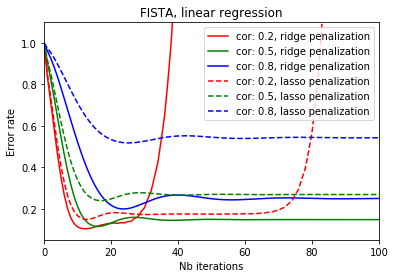

lipschitz constant: [2.2878884763358505, 4.018869938963711, 10.217285063664177]
lipschitz constant:  [0.6220697000717028, 0.977688639877881, 2.27160596538958]


In [23]:
# Linear regression, both penalizations
fig = plt.figure()
plt.plot(low_rf[2], 'r', label = 'cor: 0.2, ridge penalization')
plt.plot(med_rf[2], 'g', label = 'cor: 0.5, ridge penalization')
plt.plot(high_rf[2], 'b', label = 'cor: 0.8, ridge penalization')
plt.plot(low_lf[2], 'r--', label = 'cor: 0.2, lasso penalization')
plt.plot(med_lf[2], 'g--', label = 'cor: 0.5, lasso penalization')
plt.plot(high_lf[2], 'b--', label = 'cor: 0.8, lasso penalization')
plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 100)
plt.ylim(0.05, 1.1)
plt.title('FISTA, linear regression')
plt.legend()
plt.show()
print("lipschitz constant:", Constante_lin)
print("lipschitz constant: ", Constante_log)

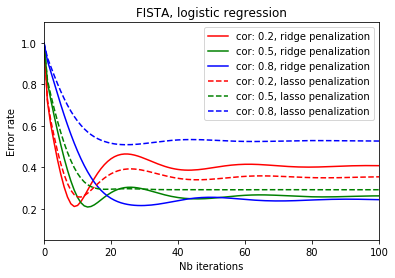

lipschitz constant: [2.2878884763358505, 4.018869938963711, 10.217285063664177]
lipschitz constant:  [0.6220697000717028, 0.977688639877881, 2.27160596538958]


In [24]:
# Logistic regression

fig = plt.figure()
plt.plot(low_log_rf[2], 'r', label = 'cor: 0.2, ridge penalization')
plt.plot(med_log_rf[2], 'g', label = 'cor: 0.5, ridge penalization')
plt.plot(high_log_rf[2], 'b', label = 'cor: 0.8, ridge penalization')
plt.plot(low_log_lf[2], 'r--', label = 'cor: 0.2, lasso penalization')
plt.plot(med_log_lf[2], 'g--', label = 'cor: 0.5, lasso penalization')
plt.plot(high_log_lf[2], 'b--', label = 'cor: 0.8, lasso penalization')
plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 100)
plt.ylim(0.05, 1.1)
plt.title('FISTA, logistic regression')
plt.legend()
plt.show()
print("lipschitz constant:", Constante_lin)
print("lipschitz constant: ", Constante_log)

### Ista

#### Linear regression (Ridge + Lasso)

In [25]:
# linear regression (with ridge and lasso penalization)
Constante_lin = []

A, b = simu_linreg(coefs, n_samples=200, corr=0.2)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
low_r = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
low_l = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
med_r = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
med_l = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_linreg(coefs, n_samples=200, corr=0.8)
step= 1/lip_linreg(A)
Constante_lin.append(lip_linreg(A))
high_r = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=s, n_iter =200)
high_l = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=s, n_iter =200) 

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.19e+00 | 8.41e-01
      10 | 5.51e-01 | 2.49e-01
      20 | 5.23e-01 | 1.47e-01
      30 | 5.20e-01 | 1.28e-01
      40 | 5.20e-01 | 1.24e-01
      50 | 5.20e-01 | 1.23e-01
      60 | 5.20e-01 | 1.23e-01
      70 | 5.20e-01 | 1.23e-01
      80 | 5.20e-01 | 1.23e-01
      90 | 5.20e-01 | 1.23e-01
     100 | 5.20e-01 | 1.23e-01
     110 | 5.20e-01 | 1.23e-01
     120 | 5.20e-01 | 1.23e-01
     130 | 5.20e-01 | 1.23e-01
     140 | 5.20e-01 | 1.23e-01
     150 | 5.20e-01 | 1.23e-01
     160 | 5.20e-01 | 1.23e-01
     170 | 5.20e-01 | 1.23e-01
     180 | 5.20e-01 | 1.23e-01
     190 | 5.20e-01 | 1.23e-01
     200 | 5.20e-01 | 1.23e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.23e+00 | 8.54e-01
      10 | 6.31e-01 | 3.12e-01
      20 | 5.97e-01 | 2.10e-01
      30 | 5.92e-01 | 1.87e-01
      40 | 5.91e-01 | 1.81e-01
      50 | 5.91e-01 | 1.79e-01
      60 | 5.91e-01 | 1.79e-01
      70 | 5.91e-01 | 

### Ista

#### Logistics regression (Ridge + Lasso)

In [26]:
# logistic regression (with ridge and lasso penalization)
Constante_log = []

A, b = simu_logreg(coefs, n_samples=200, corr=0.2)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
low_log_r = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
low_log_l = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
med_log_r = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
med_log_l = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

A, b = simu_logreg(coefs, n_samples=200, corr=0.8)
step= 1/lip_logreg(A)
Constante_log.append(lip_logreg(A))
high_log_r = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=s, n_iter =200)
high_log_l = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=s, n_iter =200)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.10e-01 | 7.02e-01
      10 | 4.00e-01 | 2.67e-01
      20 | 3.92e-01 | 2.09e-01
      30 | 3.91e-01 | 2.48e-01
      40 | 3.91e-01 | 2.95e-01
      50 | 3.91e-01 | 3.31e-01
      60 | 3.92e-01 | 3.58e-01
      70 | 3.93e-01 | 3.78e-01
      80 | 3.93e-01 | 3.92e-01
      90 | 3.93e-01 | 4.02e-01
     100 | 3.93e-01 | 4.10e-01
     110 | 3.94e-01 | 4.15e-01
     120 | 3.94e-01 | 4.19e-01
     130 | 3.94e-01 | 4.21e-01
     140 | 3.94e-01 | 4.23e-01
     150 | 3.94e-01 | 4.25e-01
     160 | 3.94e-01 | 4.26e-01
     170 | 3.94e-01 | 4.27e-01
     180 | 3.94e-01 | 4.27e-01
     190 | 3.94e-01 | 4.28e-01
     200 | 3.94e-01 | 4.28e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.41e-01 | 7.12e-01
      10 | 4.54e-01 | 3.31e-01
      20 | 4.51e-01 | 2.55e-01
      30 | 4.51e-01 | 2.55e-01
      40 | 4.52e-01 | 2.74e-01
      50 | 4.52e-01 | 2.95e-01
      60 | 4.53e-01 | 3.13e-01
      70 | 4.54e-01 | 

### Results plotting


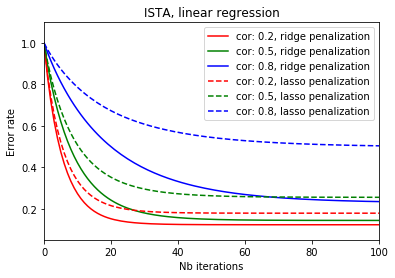

lipschitz constant: [2.37062308814709, 3.7662899223994226, 8.828754208686114]
lipschitz constant:  [0.584403142886704, 1.038830992854666, 2.1953765636436766]


In [27]:
# Linear regression

fig = plt.figure()
plt.plot(low_r[2], 'r', label = 'cor: 0.2, ridge penalization')
plt.plot(med_r[2], 'g', label = 'cor: 0.5, ridge penalization')
plt.plot(high_r[2], 'b', label = 'cor: 0.8, ridge penalization')
plt.plot(low_l[2], 'r--', label = 'cor: 0.2, lasso penalization')
plt.plot(med_l[2], 'g--', label = 'cor: 0.5, lasso penalization')
plt.plot(high_l[2], 'b--', label = 'cor: 0.8, lasso penalization')
plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 100)
plt.ylim(0.05, 1.1)
plt.title('ISTA, linear regression')
plt.legend()
plt.show()
print("lipschitz constant:", Constante_lin)
print("lipschitz constant: ", Constante_log)

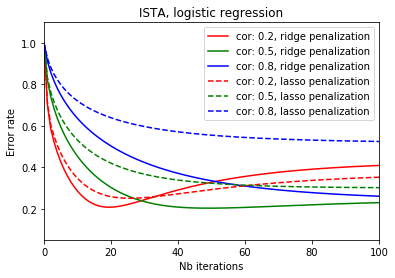

lipschitz constant: [2.37062308814709, 3.7662899223994226, 8.828754208686114]
lipschitz constant:  [0.584403142886704, 1.038830992854666, 2.1953765636436766]


In [28]:
# Logistic regression

fig = plt.figure()
plt.plot(low_log_r[2], 'r', label = 'cor: 0.2, ridge penalization')
plt.plot(med_log_r[2], 'g', label = 'cor: 0.5, ridge penalization')
plt.plot(high_log_r[2], 'b', label = 'cor: 0.8, ridge penalization')
plt.plot(low_log_l[2], 'r--', label = 'cor: 0.2, lasso penalization')
plt.plot(med_log_l[2], 'g--', label = 'cor: 0.5, lasso penalization')
plt.plot(high_log_l[2], 'b--', label = 'cor: 0.8, lasso penalization')
plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 100)
plt.ylim(0.05, 1.1)
plt.title('ISTA, logistic regression')
plt.legend()
plt.show()
print("lipschitz constant:", Constante_lin)
print("lipschitz constant: ", Constante_log)

### Ista vs Fista

We ran separately all possibles cases :
- Ista vs Fista for linear and logistic regression
- and simultanemously Ista vs Fista for ridge and lasso penalization

Both scenarios ended up with the same kind of graphs, and as the notebook is already big we chose to plot only one of these cases :
#### Ista vs Fista, with a linear regression and a ridge penalization.



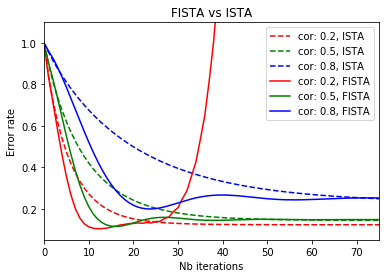

In [29]:
fig = plt.figure()
plt.plot(low_r[2], 'r--', label = 'cor: 0.2, ISTA')
plt.plot(med_r[2], 'g--', label = 'cor: 0.5, ISTA')
plt.plot(high_r[2], 'b--', label = 'cor: 0.8, ISTA')
plt.plot(low_rf[2], 'r', label = 'cor: 0.2, FISTA')
plt.plot(med_rf[2], 'g', label = 'cor: 0.5, FISTA')
plt.plot(high_rf[2], 'b', label = 'cor: 0.8, FISTA')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')
plt.xlim(0, 75)
plt.ylim(0.05, 1.1)
plt.title('FISTA vs ISTA')
plt.legend()
plt.show()

## Observations

- The Lipschitz constant tends to increase with the correlation level
- Fista and Isata algos have convergeance rates proportional to this constant
- So, the convergences of these algorithms is higher with a small correlation

- Furthermore, Fista appears to have a stronger convergence than Ista.

### The influence of the level of ridge penalization on the performance of the optimization algorithms.

### Fista

#### Linear regression

In [30]:
# linear regression
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_linreg(A)
lin1f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0, n_iter =200)
lin2f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.02, n_iter =200)
lin3f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
lin4f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.25, n_iter =200)
lin5f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.8, n_iter =200)
lin6f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=1, n_iter =200)
lin7f = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=5, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.31e+00 | 8.97e-01
      10 | 4.95e-01 | 1.32e-01
      20 | 4.92e-01 | 1.04e-01
      30 | 4.92e-01 | 1.07e-01
      40 | 4.92e-01 | 1.04e-01
      50 | 4.92e-01 | 1.05e-01
      60 | 4.92e-01 | 1.05e-01
      70 | 4.92e-01 | 1.05e-01
      80 | 4.92e-01 | 1.05e-01
      90 | 4.92e-01 | 1.05e-01
     100 | 4.92e-01 | 1.05e-01
     110 | 4.92e-01 | 1.05e-01
     120 | 4.92e-01 | 1.05e-01
     130 | 4.92e-01 | 1.05e-01
     140 | 4.92e-01 | 1.05e-01
     150 | 4.92e-01 | 1.05e-01
     160 | 4.92e-01 | 1.05e-01
     170 | 4.92e-01 | 1.05e-01
     180 | 4.92e-01 | 1.05e-01
     190 | 4.92e-01 | 1.05e-01
     200 | 4.92e-01 | 1.05e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.32e+00 | 8.99e-01
      10 | 5.56e-01 | 2.04e-01
      20 | 5.59e-01 | 2.07e-01
      30 | 5.58e-01 | 2.06e-01
      40 | 5.58e-01 | 2.06e-01
      50 | 5.58e-01 | 2.06e-01
      60 | 5.58e-01 | 2.06e-01
      70 | 5.58e-01 

C:\Users\piega\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


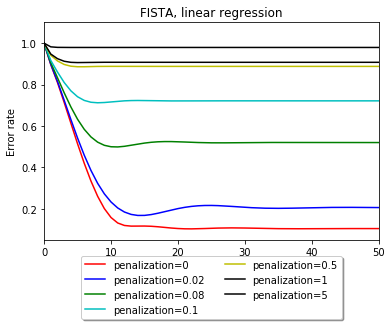

In [31]:
#Linear regression
fig = plt.figure()
plt.plot(lin1f[2], 'r', label = 'penalization=0')
plt.plot(lin2f[2], 'b', label = 'penalization=0.02')
plt.plot(lin3f[2], 'g', label = 'penalization=0.08')
plt.plot(lin4f[2], 'c', label = 'penalization=0.1')
plt.plot(lin5f[2], 'y', label = 'penalization=0.5')
plt.plot(lin6f[2], 'k', label = 'penalization=1')
plt.plot(lin7f[2], 'k', label = 'penalization=5')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('FISTA, linear regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

#### Logistic regression

In [32]:
# logistic regression
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
log1f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0, n_iter =200)
log2f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.02, n_iter =200)
log3f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
log4f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.25, n_iter =200)
log5f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.8, n_iter =200)
log6f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=1, n_iter =200)
log7f = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=5, n_iter =200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.38e-01 | 8.30e-01
      10 | 3.70e-01 | 2.22e-01
      20 | 3.37e-01 | 5.83e-01
      30 | 3.27e-01 | 1.01e+00
      40 | 3.24e-01 | 1.31e+00
      50 | 3.24e-01 | 1.51e+00
      60 | 3.24e-01 | 1.62e+00
      70 | 3.24e-01 | 1.66e+00
      80 | 3.24e-01 | 1.65e+00
      90 | 3.24e-01 | 1.61e+00
     100 | 3.24e-01 | 1.56e+00
     110 | 3.24e-01 | 1.51e+00
     120 | 3.24e-01 | 1.47e+00
     130 | 3.24e-01 | 1.46e+00
     140 | 3.24e-01 | 1.47e+00
     150 | 3.24e-01 | 1.49e+00
     160 | 3.24e-01 | 1.51e+00
     170 | 3.24e-01 | 1.53e+00
     180 | 3.24e-01 | 1.55e+00
     190 | 3.24e-01 | 1.55e+00
     200 | 3.24e-01 | 1.54e+00
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.42e-01 | 8.33e-01
      10 | 4.20e-01 | 3.01e-01
      20 | 4.18e-01 | 2.16e-01
      30 | 4.18e-01 | 2.43e-01
      40 | 4.18e-01 | 2.42e-01
      50 | 4.18e-01 | 2.35e-01
      60 | 4.18e-01 | 2.40e-01
      70 | 4.18e-01 

C:\Users\piega\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


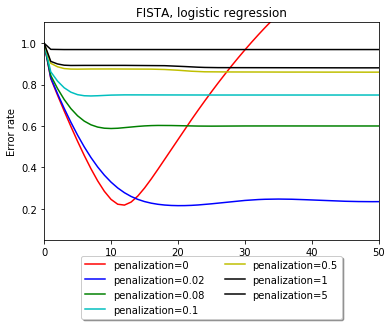

In [33]:
#Logistic regression
fig = plt.figure()
plt.plot(log1f[2], 'r', label = 'penalization=0')
plt.plot(log2f[2], 'b', label = 'penalization=0.02')
plt.plot(log3f[2], 'g', label = 'penalization=0.08')
plt.plot(log4f[2], 'c', label = 'penalization=0.1')
plt.plot(log5f[2], 'y', label = 'penalization=0.5')
plt.plot(log6f[2], 'k', label = 'penalization=1')
plt.plot(log7f[2], 'k', label = 'penalization=5')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('FISTA, logistic regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

### Ista

#### Linear regression

In [34]:
# linear regression
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1 / lip_linreg(A)
lin1= ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0, n_iter =200)
lin2 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.02, n_iter =200)
lin3 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.08, n_iter =200)
lin4 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
lin5 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.5, n_iter =200)
lin6 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=1, n_iter =200)
lin7 = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=5, n_iter =200)


Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.32e+00 | 9.00e-01
      10 | 6.04e-01 | 3.75e-01
      20 | 5.12e-01 | 1.92e-01
      30 | 4.96e-01 | 1.30e-01
      40 | 4.93e-01 | 1.12e-01
      50 | 4.92e-01 | 1.07e-01
      60 | 4.92e-01 | 1.06e-01
      70 | 4.92e-01 | 1.05e-01
      80 | 4.92e-01 | 1.05e-01
      90 | 4.92e-01 | 1.05e-01
     100 | 4.92e-01 | 1.05e-01
     110 | 4.92e-01 | 1.05e-01
     120 | 4.92e-01 | 1.05e-01
     130 | 4.92e-01 | 1.05e-01
     140 | 4.92e-01 | 1.05e-01
     150 | 4.92e-01 | 1.05e-01
     160 | 4.92e-01 | 1.05e-01
     170 | 4.92e-01 | 1.05e-01
     180 | 4.92e-01 | 1.05e-01
     190 | 4.92e-01 | 1.05e-01
     200 | 4.92e-01 | 1.05e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.33e+00 | 9.02e-01
      10 | 6.66e-01 | 4.28e-01
      20 | 5.84e-01 | 2.84e-01
      30 | 5.67e-01 | 2.36e-01
      40 | 5.62e-01 | 2.20e-01
      50 | 5.60e-01 | 2.14e-01
      60 | 5.60e-01 | 2.11e-01
      70 | 5.60e-01 | 

C:\Users\piega\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


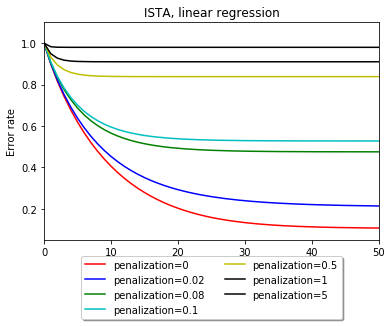

In [35]:
#Linear regression
fig = plt.figure()
plt.plot(lin1[2], 'r', label = 'penalization=0')
plt.plot(lin2[2], 'b', label = 'penalization=0.02')
plt.plot(lin3[2], 'g', label = 'penalization=0.08')
plt.plot(lin4[2], 'c', label = 'penalization=0.1')
plt.plot(lin5[2], 'y', label = 'penalization=0.5')
plt.plot(lin6[2], 'k', label = 'penalization=1')
plt.plot(lin7[2], 'k', label = 'penalization=5')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('ISTA, linear regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

### Ista

#### Logistic regression

In [36]:
# logistic regression
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1/lip_logreg(A)
log1= ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0, n_iter =200)
log2 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.02, n_iter =200)
log3 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.08, n_iter =200)
log4 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
log5 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.5, n_iter =200)
log6 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=1, n_iter =200)
log7 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=5, n_iter =200)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.28e-01 | 8.05e-01
      10 | 4.00e-01 | 3.79e-01
      20 | 3.74e-01 | 2.31e-01
      30 | 3.61e-01 | 2.22e-01
      40 | 3.53e-01 | 2.85e-01
      50 | 3.47e-01 | 3.63e-01
      60 | 3.43e-01 | 4.38e-01
      70 | 3.40e-01 | 5.07e-01
      80 | 3.37e-01 | 5.69e-01
      90 | 3.36e-01 | 6.26e-01
     100 | 3.34e-01 | 6.78e-01
     110 | 3.33e-01 | 7.26e-01
     120 | 3.32e-01 | 7.70e-01
     130 | 3.31e-01 | 8.10e-01
     140 | 3.30e-01 | 8.47e-01
     150 | 3.29e-01 | 8.82e-01
     160 | 3.29e-01 | 9.14e-01
     170 | 3.28e-01 | 9.45e-01
     180 | 3.28e-01 | 9.73e-01
     190 | 3.27e-01 | 9.99e-01
     200 | 3.27e-01 | 1.02e+00
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.33e-01 | 8.08e-01
      10 | 4.31e-01 | 4.36e-01
      20 | 4.21e-01 | 3.20e-01
      30 | 4.19e-01 | 2.69e-01
      40 | 4.18e-01 | 2.43e-01
      50 | 4.18e-01 | 2.30e-01
      60 | 4.18e-01 | 2.23e-01
      70 | 4.18e-01 | 

C:\Users\piega\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


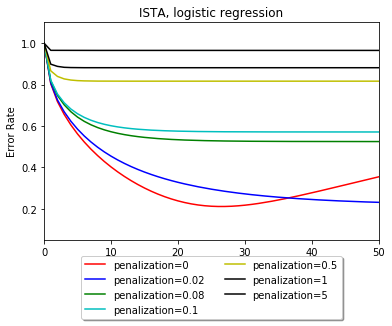

In [37]:
#Logistic regression
fig = plt.figure()
plt.plot(log1[2], 'r', label = 'penalization=0')
plt.plot(log2[2], 'b', label = 'penalization=0.02')
plt.plot(log3[2], 'g', label = 'penalization=0.08')
plt.plot(log4[2], 'c', label = 'penalization=0.1')
plt.plot(log5[2], 'y', label = 'penalization=0.5')
plt.plot(log6[2], 'k', label = 'penalization=1')
plt.plot(log7[2], 'k', label = 'penalization=5')

plt.xlabel('Nb iterations')
plt.ylabel('Error Rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('ISTA, logistic regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

### Fista vs Ista

As previouslsy, we chose to display only one case, linear loss, as we noticed the conclusion would be the same with any case.

C:\Users\piega\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


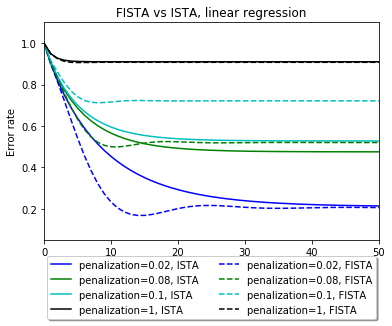

In [38]:

fig = plt.figure()
plt.plot(lin2[2], 'b', label = 'penalization=0.02, ISTA')
plt.plot(lin3[2], 'g', label = 'penalization=0.08, ISTA')
plt.plot(lin4[2], 'c', label = 'penalization=0.1, ISTA')
plt.plot(lin6[2], 'k', label = 'penalization=1, ISTA')
plt.plot(lin2f[2], 'b--', label = 'penalization=0.02, FISTA')
plt.plot(lin3f[2], 'g--', label = 'penalization=0.08, FISTA')
plt.plot(lin4f[2], 'c--', label = 'penalization=0.1, FISTA')
plt.plot(lin6f[2], 'k--', label = 'penalization=1, FISTA')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0, 50)
plt.ylim(0.05, 1.1)
plt.title('FISTA vs ISTA, linear regression')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.show()

## Observations

- This time, the algorithms converge faster with a high penalization
- However, it lso induces a higher error rate

We can relate it to the first part of the lab --> the coefficient values shrinkage was due to the penalization, leading to errors.

We can feel here the role of this penalization : we can see how it leads to an underfitting if it's too large.

### The performance of the optimization algorithms for ridge and lasso penalizations.

### Fista

#### Linear regression

In [39]:
# linear regression small penalisation
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step = 1 / lip_linreg(A)
lin_r_smallpen = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.01, n_iter =200)
lin_l_smallpen = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=0.01, n_iter =200)

# linear regression strong penalisation
lin_r_strongpen = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
lin_l_strongpen = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=0.1, n_iter =200)


Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.32e+00 | 8.99e-01
      10 | 5.25e-01 | 1.63e-01
      20 | 5.23e-01 | 1.38e-01
      30 | 5.24e-01 | 1.47e-01
      40 | 5.23e-01 | 1.42e-01
      50 | 5.23e-01 | 1.45e-01
      60 | 5.23e-01 | 1.44e-01
      70 | 5.23e-01 | 1.44e-01
      80 | 5.23e-01 | 1.44e-01
      90 | 5.23e-01 | 1.44e-01
     100 | 5.23e-01 | 1.44e-01
     110 | 5.23e-01 | 1.44e-01
     120 | 5.23e-01 | 1.44e-01
     130 | 5.23e-01 | 1.44e-01
     140 | 5.23e-01 | 1.44e-01
     150 | 5.23e-01 | 1.44e-01
     160 | 5.23e-01 | 1.44e-01
     170 | 5.23e-01 | 1.44e-01
     180 | 5.23e-01 | 1.44e-01
     190 | 5.23e-01 | 1.44e-01
     200 | 5.23e-01 | 1.44e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 1.36e+00 | 9.13e-01
      10 | 6.20e-01 | 2.88e-01
      20 | 6.08e-01 | 2.45e-01
      30 | 6.13e-01 | 2.63e-01
      40 | 6.11e-01 | 2.54e-01
      50 | 6.12e-01 | 2.58e-01
      60 | 6.11e-01 | 2.57e-01
      70 | 6.12e-01 

#### Logistic regression

In [40]:
# logistic regression small penalisation
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step = 1 / lip_logreg(A)
log_r_smallpen = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.01, n_iter=200)
log_l_smallpen = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=0.01, n_iter=200)

# logistic regression strong penalisation
log_r_strongpen = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.1, n_iter=200)
log_l_strongpen = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=0.1, n_iter=200)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.33e-01 | 8.12e-01
      10 | 3.96e-01 | 2.31e-01
      20 | 3.91e-01 | 2.83e-01
      30 | 3.91e-01 | 2.86e-01
      40 | 3.91e-01 | 2.49e-01
      50 | 3.91e-01 | 2.49e-01
      60 | 3.91e-01 | 2.63e-01
      70 | 3.91e-01 | 2.61e-01
      80 | 3.91e-01 | 2.55e-01
      90 | 3.91e-01 | 2.56e-01
     100 | 3.91e-01 | 2.59e-01
     110 | 3.91e-01 | 2.58e-01
     120 | 3.91e-01 | 2.56e-01
     130 | 3.91e-01 | 2.57e-01
     140 | 3.91e-01 | 2.58e-01
     150 | 3.91e-01 | 2.57e-01
     160 | 3.91e-01 | 2.57e-01
     170 | 3.91e-01 | 2.58e-01
     180 | 3.91e-01 | 2.58e-01
     190 | 3.91e-01 | 2.57e-01
     200 | 3.91e-01 | 2.57e-01
Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 5.55e-01 | 8.25e-01
      10 | 4.52e-01 | 3.51e-01
      20 | 4.49e-01 | 2.96e-01
      30 | 4.49e-01 | 2.94e-01
      40 | 4.49e-01 | 2.93e-01
      50 | 4.49e-01 | 2.93e-01
      60 | 4.49e-01 | 2.93e-01
      70 | 4.49e-01 

C:\Users\piega\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


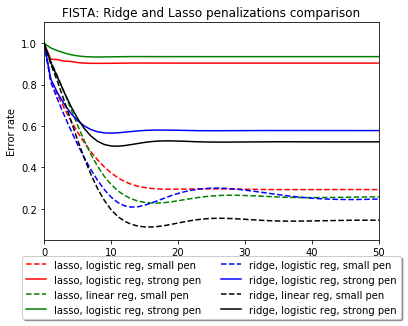

In [41]:
plt.plot(log_l_smallpen[2], 'r--', label = 'lasso, logistic reg, small pen')
plt.plot(log_l_strongpen[2], 'r', label = 'lasso, logistic reg, strong pen')

plt.plot(lin_l_smallpen[2], 'g--', label = 'lasso, linear reg, small pen')
plt.plot(lin_l_strongpen[2], 'g', label = 'lasso, logistic reg, strong pen')

plt.plot(log_r_smallpen[2], 'b--', label = 'ridge, logistic reg, small pen')
plt.plot(log_r_strongpen[2], 'b', label = 'ridge, logistic reg, strong pen')

plt.plot(lin_r_smallpen[2], 'k--', label = 'ridge, linear reg, small pen')
plt.plot(lin_r_strongpen[2], 'k', label = 'ridge, logistic reg, strong pen')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0,50)
plt.ylim(0.05, 1.1)
plt.title('FISTA: Ridge and Lasso penalizations comparison')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
#plt.legend()
plt.show()

### The performance of the optimization algorithms for ridge and lasso penalizations.

### Ista

#### Linear regression

In [42]:
# linear regression small penalization
A, b = simu_linreg(coefs, n_samples=200, corr=0.5)
step= 1. / lip_linreg(A)
lin_r_smallpen= ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.01, n_iter =200)
lin_l_smallpenl= ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=0.01, n_iter =200)

# linear regression strong penalization
lin_r_strongpen= ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
lin_l_strongpen= ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step, s=0.1, n_iter =200)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.31e+00 | 8.95e-01
      10 | 6.22e-01 | 3.83e-01
      20 | 5.43e-01 | 2.24e-01
      30 | 5.28e-01 | 1.71e-01
      40 | 5.25e-01 | 1.53e-01
      50 | 5.23e-01 | 1.46e-01
      60 | 5.23e-01 | 1.43e-01
      70 | 5.23e-01 | 1.42e-01
      80 | 5.23e-01 | 1.42e-01
      90 | 5.23e-01 | 1.42e-01
     100 | 5.23e-01 | 1.42e-01
     110 | 5.23e-01 | 1.42e-01
     120 | 5.23e-01 | 1.42e-01
     130 | 5.23e-01 | 1.42e-01
     140 | 5.23e-01 | 1.42e-01
     150 | 5.23e-01 | 1.42e-01
     160 | 5.23e-01 | 1.42e-01
     170 | 5.23e-01 | 1.42e-01
     180 | 5.23e-01 | 1.42e-01
     190 | 5.23e-01 | 1.42e-01
     200 | 5.23e-01 | 1.42e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.35e+00 | 9.09e-01
      10 | 7.28e-01 | 4.71e-01
      20 | 6.41e-01 | 3.33e-01
      30 | 6.20e-01 | 2.83e-01
      40 | 6.13e-01 | 2.63e-01
      50 | 6.11e-01 | 2.55e-01
      60 | 6.10e-01 | 2.52e-01
      70 | 6.09e-01 | 

#### Logistic regression

In [43]:
# logistic regression small penalization
A, b = simu_logreg(coefs, n_samples=200, corr=0.5)
step= 1. / lip_logreg(A)
log_r_smallpen= ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.01, n_iter =200)
log_l_smallpen= ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=0.01, n_iter =200)

# logistic regression strong penalization
log_r_strongpen= ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step, s=0.1, n_iter =200)
log_l_strongpen= ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step, s=0.1, n_iter =200)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.31e-01 | 8.09e-01
      10 | 4.17e-01 | 4.12e-01
      20 | 4.01e-01 | 2.75e-01
      30 | 3.95e-01 | 2.19e-01
      40 | 3.93e-01 | 2.04e-01
      50 | 3.92e-01 | 2.07e-01
      60 | 3.91e-01 | 2.15e-01
      70 | 3.91e-01 | 2.25e-01
      80 | 3.91e-01 | 2.33e-01
      90 | 3.91e-01 | 2.40e-01
     100 | 3.91e-01 | 2.45e-01
     110 | 3.91e-01 | 2.50e-01
     120 | 3.91e-01 | 2.53e-01
     130 | 3.91e-01 | 2.55e-01
     140 | 3.91e-01 | 2.57e-01
     150 | 3.91e-01 | 2.59e-01
     160 | 3.91e-01 | 2.60e-01
     170 | 3.91e-01 | 2.60e-01
     180 | 3.91e-01 | 2.61e-01
     190 | 3.91e-01 | 2.61e-01
     200 | 3.91e-01 | 2.62e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 5.54e-01 | 8.21e-01
      10 | 4.66e-01 | 4.94e-01
      20 | 4.55e-01 | 3.91e-01
      30 | 4.52e-01 | 3.42e-01
      40 | 4.51e-01 | 3.17e-01
      50 | 4.50e-01 | 3.05e-01
      60 | 4.50e-01 | 2.98e-01
      70 | 4.49e-01 | 

C:\Users\piega\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


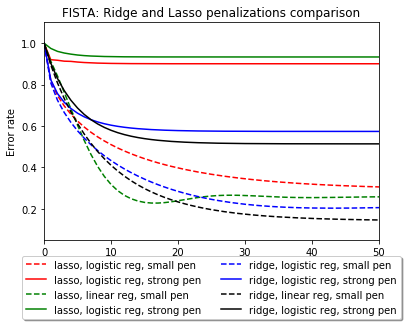

In [44]:
plt.plot(log_l_smallpen[2], 'r--', label = 'lasso, logistic reg, small pen')
plt.plot(log_l_strongpen[2], 'r', label = 'lasso, logistic reg, strong pen')

plt.plot(lin_l_smallpen[2], 'g--', label = 'lasso, linear reg, small pen')
plt.plot(lin_l_strongpen[2], 'g', label = 'lasso, logistic reg, strong pen')

plt.plot(log_r_smallpen[2], 'b--', label = 'ridge, logistic reg, small pen')
plt.plot(log_r_strongpen[2], 'b', label = 'ridge, logistic reg, strong pen')

plt.plot(lin_r_smallpen[2], 'k--', label = 'ridge, linear reg, small pen')
plt.plot(lin_r_strongpen[2], 'k', label = 'ridge, logistic reg, strong pen')

plt.xlabel('Nb iterations')
plt.ylabel('Error rate')

plt.xlim(0,50)
plt.ylim(0.05, 1.1)
plt.title('FISTA: Ridge and Lasso penalizations comparison')
ax = plt.subplot(111)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
#plt.legend()
plt.show()

## Observations

Finally, with the above part, we can see that a strong penalization will slow down the convergence.